Objective: carry out a hierarchical dirichlet process analysis to identify topics shared accross meta analytic terms, thus clustering them

In [2]:
project_dir = '/homes_unix/agillig/github_repos/ginna'

In [3]:
from func_toolbox import fetch_neurosynth_data

import itertools
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt 

from pathlib import Path
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import re

from pprint import pprint

from nimare.extract import download_abstracts, fetch_neuroquery, fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset

seed = 15011999
np.random.seed(seed)


# I. Semantic analysis

## Step 1: gathering text data

### 1.1. list of all included articles for each of the 506 meta-analytic terms

### 1.2. extract text data from each article

For now we will just extract the whole neurosynth db using nimare, ask valentina for the exact list of articles

In [4]:
###############################################################################
# Download Neurosynth
# -----------------------------------------------------------------------------
# Neurosynth's data files are stored at https://github.com/neurosynth/neurosynth-data.
out_dir = '/scratch/agillig/db'
os.makedirs(out_dir, exist_ok=True)

files = fetch_neurosynth(
    data_dir=out_dir,
    version="7",
    overwrite=False,
    source="abstract",
    vocab="terms",
)
# Note that the files are saved to a new folder within "out_dir" named "neurosynth".
pprint(files)
neurosynth_db = files[0]

INFO:nimare.extract.utils:Dataset found in /scratch/agillig/db/neurosynth

INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('source-abstract', 'vocab-terms', 'data-neurosynth', 'version-7')]


File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
[{'coordinates': '/scratch/agillig/db/neurosynth/data-neurosynth_version-7_coordinates.tsv.gz',
  'features': [{'features': '/scratch/agillig/db/neurosynth/data-neurosynth_version-7_vocab-terms_source-abstract_type-tfidf_features.npz',
                'vocabulary': '/scratch/agillig/db/neurosynth/data-neurosynth_version-7_vocab-terms_vocabulary.txt'}],
  'metadata': '/scratch/agillig/db/neurosynth/data-neurosynth_version-7_metadata.tsv.gz'}]


# fetch neurosynth dataset

In [5]:
from nimare.dataset import Dataset
nsynth_abstracts_dset = os.path.join(out_dir, "neurosynth_dataset_with_abstracts.pkl.gz")

if os.path.isfile(nsynth_abstracts_dset) == False:
    # # Convert Neurosynth database to NiMARE dataset file
    neurosynth_dset = convert_neurosynth_to_dataset(
        coordinates_file=neurosynth_db["coordinates"],
        metadata_file=neurosynth_db["metadata"],
        annotations_files=neurosynth_db["features"],
    )
    neurosynth_dset.save(os.path.join(out_dir, "neurosynth_dataset.pkl.gz"))
    print(neurosynth_dset)

    # Add article abstracts to dataset
    neurosynth_dset = download_abstracts(neurosynth_dset, "example@example.edu")
    neurosynth_dset.save(os.path.join(out_dir, "neurosynth_dataset_with_abstracts.pkl.gz"))
else:
    neurosynth_dset = Dataset.load(nsynth_abstracts_dset)
titles = np.array(neurosynth_dset.metadata['title'], dtype='str')
abstracts = np.array(neurosynth_dset.texts['abstract'], dtype='str')

In [6]:
neurosynth_corpus = []
for i in range(len(titles)):
    concat = titles[i] + ' ' + abstracts[i]
    neurosynth_corpus.append(concat)
    # print(ttl)

# extract cognitive concepts from the cognitive atlas ontology

In [7]:
# Function to extract text from a web page
def extract_text_from_webpage(url):
    # Fetch the web page content
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract text from all anchor tags with href attribute
    links = soup.find_all('a', href=True)
    link_texts = [link.get_text() for link in links]

    return link_texts

# Function to extract words from text
def extract_words(text):
    words = re.findall(r'\b\w+\b', text)
    return words

# Function to extract sentences from text
def extract_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return sentences

# Example usage
url = 'https://www.cognitiveatlas.org/concepts/categories/all'
text = extract_text_from_webpage(url)
# words = extract_words(text)
# sentences = extract_sentences(text)

# print("Words:", words)
# print("Sentences:", sentences)

# remove uppercase elements (they are not concepts but titles of html elements)
cogatlas_concepts = [s for s in text if s and not s[0].isupper()]
remove = ['\n', 'cognitiveatlas NIMH Grant RO1MH082795, Russell Poldrack, PI.',
          'cognitive control', 'theory of mind', 'language', 'working memory', 'memory']
remove = ['\n', 'cognitiveatlas NIMH Grant RO1MH082795, Russell Poldrack, PI.']
cogatlas_concepts = [s for s in cogatlas_concepts if s not in remove]

In [10]:
neurosynth_terms_file = project_dir + '/data/terms/BCS_3D.csv'
os.makedirs(Path(neurosynth_terms_file).parent, exist_ok=True)

# download the file from the Pacela et al. 2021 paper repo 
# https://github.com/vale-pak/BCS

if not os.path.exists(neurosynth_terms_file):
    fetch_neurosynth_data(f'{project_dir}/data')

# https://github.com/vale-pak/BCS/blob/main/BCS_3D.csv
df = pd.read_csv(neurosynth_terms_file, sep = ',')

neurosynth_terms = df['Functions']
neurosynth_terms = [s.replace('_', ' ') for s in neurosynth_terms]

## embed all cogatlas concepts based on tf idf matrix

In [ ]:
# extract significant terms and associated Pearson correlations for a given RSN 
import json
corrp_file = f'{project_dir}/results/rsn_p_maxcorc_termwise.json'
with open(corrp_file, 'r') as f:
    json_data = json.load(f)

df = pd.DataFrame.from_dict(json_data).T
df.columns = neurosynth_terms

pvals_df = df.map(lambda x: x < 0.05)
df = pvals_df

pearsonr_file = f'{project_dir}/results/rsn_Pearsonr.json'
with open(pearsonr_file, 'r') as f:
    json_data = json.load(f)

pearsonr_df = pd.DataFrame.from_dict(json_data).T
pearsonr_df.columns = neurosynth_terms

cognitive_labeling_file = f'{project_dir}/results/RSN41_cognitive_labeling.xlsx'
RSN_numbering = pd.read_excel(cognitive_labeling_file, index_col=0)['Numbering']
df.index = RSN_numbering
df.sort_index(inplace=True)

pearsonr_df.index = RSN_numbering
pearsonr_df.sort_index(inplace=True)



In [13]:
from nltk.stem.snowball import SnowballStemmer
import nltk
import re
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def stem_single_words_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for word in text]
    stems = [stemmer.stem(t) for t in tokens]
    return stems

def remove_stop_words(tokens):
    is_stopword = [any([tk == stopw for stopw in stopwords]) for tk in tokens]
    not_stopword = [False if i == True else True for i in is_stopword]
    cleaned_tokens = list(np.array(tokens)[np.array(not_stopword, dtype='bool')])
    return cleaned_tokens

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english',)
print(stopwords)
stopwords = [tokenize_and_stem(s) for s in stopwords]
stopwords = list(itertools.chain(*stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /homes_unix/agillig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /homes_unix/agillig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
test_cogatlas_concepts = [tokenize_and_stem(s) for s in cogatlas_concepts]
test_cogatlas_concepts = [' '.join(c) for c in test_cogatlas_concepts]

In [16]:
vocabulary = list(set(cogatlas_concepts).union(set(df.columns)))
vocabulary.sort()
tokenized_vocabulary = [tokenize_and_stem(voc) for voc in vocabulary]
tokenized_vocabulary = list(set(itertools.chain(*tokenized_vocabulary)))
tokenized_vocabulary.sort()

In [ ]:
count_model = CountVectorizer(min_df=0.001, 
                              max_df=0.8, 
                              tokenizer=tokenize_and_stem, 
                              stop_words=stopwords, 
                              ngram_range=(1,2))
count_model.fit(neurosynth_corpus)

vocabulary = count_model.get_feature_names_out().tolist()
print('vocabulary length:', len(vocabulary))


# tokenized_cogatlas_concepts = list(set([' '.join(tokenize_and_stem(s)) for s in cogatlas_concepts]))
# tokenized_cogatlas_onegrams = list(set(itertools.chain(*tokenized_cogatlas_concepts)))

missing_onegrams = [token for token in tokenized_vocabulary if token not in count_model.vocabulary_]
n_bigrams_absent = len(missing_onegrams)

if n_bigrams_absent > 0:
    print(f'there are {n_bigrams_absent} terms/concepts not present in the vocabulary; appending and refitting...')
    for ngram in missing_onegrams:
        vocabulary.append(ngram)
    count_model = CountVectorizer(min_df=0.001, max_df=0.8, 
                                    tokenizer=tokenize_and_stem, stop_words=stopwords, ngram_range=(1,2),
                                    vocabulary=vocabulary)
    X = count_model.fit_transform(neurosynth_corpus)



print('performing dimensionality reduction...')
# use Truncated SVD, cf https://scikit-learn.org/stable/modules/decomposition.html#lsa
# tfid with sublinear_tf=True, use_idf=True should be used
tfid_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True, smooth_idf=True)
X = tfid_transformer.fit_transform(X)

embedding = TruncatedSVD(n_components=100)
X_embedded = embedding.fit_transform(X.transpose())


neurosynth_count_embedded = pd.DataFrame(X_embedded, index=vocabulary).T
print(f'n components: {X_embedded.shape[1]}')

del X


/homes_unix/agillig/.conda/envs/topicmodeling/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


vocabulary length: 18098
there are 57 terms/concepts not present in the vocabulary; appending and refitting...
performing dimensionality reduction...
n components: 100


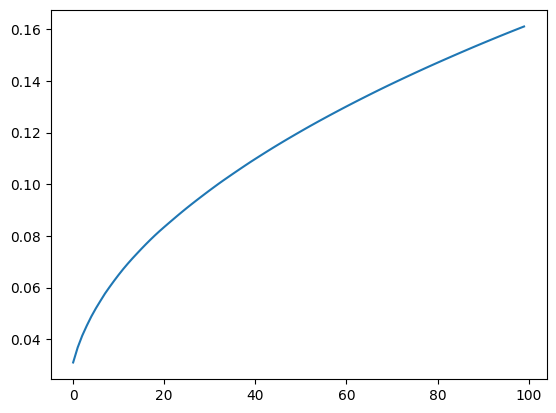

In [19]:
plt.plot(embedding.explained_variance_ratio_.cumsum())

In [20]:
def create_corpus_from_mams(terms):
    # for each term, get PMID of corresponding studies
    titles = []
    term_prefix = 'terms_abstract_tfidf__'
    studies = []
    coordinates = []
    abstracts = []
    for term in terms:
        termstuds = neurosynth_dset.get_studies_by_label(term_prefix + term)
        studies.append(termstuds)
        # print(f'term {term}, {len(termstuds)} studies')

    #avoid duplicate papers
    studies_set = set()
    for lst in studies:
        studies_set = studies_set.union(set(lst))
    studies = list(studies_set)
    is_included = [any(word in s for word in studies) for s in neurosynth_dset.metadata['id']]
    titles = list(neurosynth_dset.metadata['title'][is_included])
    print(f'total number of articles: {len(titles)}')
    abstracts = list(neurosynth_dset.texts['abstract'][is_included])
    document_corpus = []
    for i in range(len(titles)):
        if type(abstracts[i]) == float:
            continue
        concat = titles[i] + ' ' + abstracts[i]
        document_corpus.append(concat)
    return document_corpus

# process all RSNs

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# tfid = TfidfTransformer(norm='l2')

In [22]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
from tqdm.auto import tqdm

# Ignore SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)


most_central_words = {}
min_cos_word = {}
for i in range(1,34):
    RSN = f'RSN{i:02d}'
    print(RSN)

    rsn_terms = df.loc[RSN, df.loc[RSN] == True].index.tolist()
    
    tokenized_rsn_terms = [tokenize_and_stem(term) for term in rsn_terms]


    if len(rsn_terms) == 0:
        continue

    cosine_distances = {}
    for cogatlas_term in cogatlas_concepts:
        n = 0

        tokenized_cogatlas_term = tokenize_and_stem(cogatlas_term)

        working_rsn_terms = rsn_terms.copy()
        
        rsn_correlations = pearsonr_df.loc[RSN,working_rsn_terms].to_numpy()
        rsn_correlations = np.expand_dims(rsn_correlations, axis=1)
        weights = np.ones_like(rsn_correlations)

        mean_embedding_vector = np.array([np.mean([neurosynth_count_embedded[tkn] for tkn in tkn_term], axis=0) for tkn_term in tokenized_rsn_terms])
        mean_embedding_vector = (mean_embedding_vector * weights * rsn_correlations).mean(axis=0)
        cogatlas_term_vector = np.mean([neurosynth_count_embedded[tkn] for tkn in tokenized_cogatlas_term], axis=0)
        
        if cogatlas_term_vector.ndim == 2:
            cogatlas_term_vector = cogatlas_term_vector.ravel()

        if np.sum(cogatlas_term_vector) == 0:
            continue

        cosine_distances[cogatlas_term] = cosine(cogatlas_term_vector, mean_embedding_vector)   
    
    cos_df = pd.DataFrame.from_dict(cosine_distances, orient='index', columns=['cosine_distance']).sort_values(by='cosine_distance', ascending=True)

    
    max_cosine_word = cos_df.iloc[0].name
    max_cosine_value = cos_df.iloc[0].values[0]
    print(f"Word with lowest cosine distance: {max_cosine_word} (distance: {max_cosine_value:.2f})")
    min_cos_word[RSN] = max_cosine_word

RSN01
RSN02
RSN03
Word with lowest cosine distance: visual form discrimination (distance: 0.07)
RSN04
Word with lowest cosine distance: speech production (distance: 0.13)
RSN05
Word with lowest cosine distance: memory retrieval (distance: 0.02)
RSN06
Word with lowest cosine distance: motor program (distance: 0.15)
RSN07
Word with lowest cosine distance: divergent thinking (distance: 0.30)
RSN08
Word with lowest cosine distance: spatial selective attention (distance: 0.02)
RSN09
Word with lowest cosine distance: visual masking (distance: 0.02)
RSN10
Word with lowest cosine distance: motor planning (distance: 0.21)
RSN11
Word with lowest cosine distance: nociception (distance: 0.10)
RSN12
Word with lowest cosine distance: analogical reasoning (distance: 0.17)
RSN13
Word with lowest cosine distance: decision making (distance: 0.18)
RSN14
Word with lowest cosine distance: auditory tone perception (distance: 0.07)
RSN15
Word with lowest cosine distance: language comprehension (distance: 0.1

In [23]:
most_central_words_df = pd.DataFrame.from_dict(most_central_words, orient='index', columns=['most_central_word'])
min_cos_df = pd.DataFrame.from_dict(min_cos_word, orient='index', columns=['min_cos_word'])

In [24]:
experts_consensus = pd.read_excel(cognitive_labeling_file, index_col=1)
experts_consensus.sort_index(inplace=True)
experts_consensus = experts_consensus.merge(most_central_words_df, left_index=True, right_index=True, how='outer')
experts_consensus = experts_consensus.merge(min_cos_df, left_index=True, right_index=True, how='outer')
compare_data_driven = experts_consensus.loc[:, ['3 closest terms (Pearson r, p)', 'anat_label', 'Cognitive Atlas label', 'min_cos_word']]

In [25]:
# Rename specific columns
compare_data_driven = compare_data_driven.rename(columns={
    'min_cos_word': 'data-driven Cognitive Atlas label',
})
compare_data_driven

,"3 closest terms (Pearson r, p)",anat_label,Cognitive Atlas label,data-driven Cognitive Atlas label
RSN01,"mnemonic (r=0.40, p=0.07); retrieval (r=0.38, ...",pCing-medPN,n.s.,NaN
RSN02,"monitoring (r=0.32, p=0.1); signal_task (r=0.2...",R-FTPN-03,n.s.,NaN
RSN03,"visual (r=0.76, p<0.001); visual_field (r=0.54...",ON-04,"motion detection, visual object recognition",visual form discrimination
RSN04,"speech_production (r=0.69, p<0.001); oral (r=0...",PcN-02,articulation,speech production
RSN05,"autobiographical_memory (r=0.71, p<0.001); epi...",med-TN,memory retrieval,memory retrieval
RSN06,"foot (r=0.88, p<0.001); limb (r=0.72, p<0.001)...",PcN-01,movement (limb),motor program
RSN07,"default_mode (r=0.84, p<0.001); default_networ...",med-FPN,self-referential processing,divergent thinking
RSN08,"spatial (r=0.70, p<0.001); orienting (r=0.64, ...",D-FPN-03,spatial selective attention,spatial selective attention
RSN09,"early_visual (r=0.74, p<0.001); primary_visual...",ON-01,visual perception,visual masking
RSN10,"hands (r=0.70, p<0.001); action_observation (r...",D-FPN-01,motor planning,motor planning
